## Step 1: Download images of birds and non-birds

In [ ]:
!pip install duckduckgo_search

In [ ]:
!pip install fastai

In [6]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images = 30):
  print(f"Searching for  '{term}'")
  return L(ddg_images(term, max_results = max_images)).itemgot('image')

Let's search for a bird and see the results we get

In [7]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for  'bird photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'http://hdqwalls.com/download/1/colorful-parrot-bird.jpg'

And download and view the cell

In [ ]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

We do the same for forests

Searching for  'forest photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


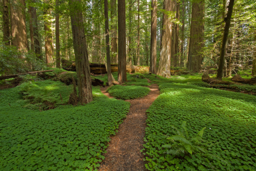

In [9]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256, 256)

Since the results look appropriate, let's download multiple images and store them into sepeerate folders for birds and forests

In [10]:
from time import sleep

searches = 'forest', 'bird'
path = Path('bird_or_not')

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photo'))
  sleep(10) # Pause between downloads to avoid overloading server
  download_images(dest, urls=search_images(f'{o} sun photo'))
  sleep(10)
  download_images(dest, urls=search_images(f'{o} shade photo'))
  resize_images(path/o, max_size=400, dest=path/o)

Searching for  'forest photo'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Searching for  'forest sun photo'
Searching for  'forest shade photo'
Searching for  'bird photo'
Searching for  'bird sun photo'
Searching for  'bird shade photo'


Some photos may not download correctly so we remove them

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

## Step 2: Train our models

We need dataloaders to train the model, which we can easily create using DataBlocks in FastAI

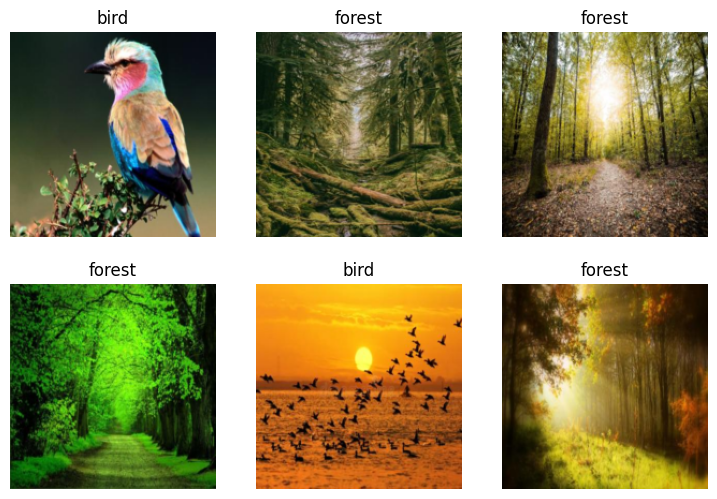

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n = 6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 281MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.801952,1.463952,0.424242,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.165657,0.191985,0.060606,00:29
1,0.093159,0.060838,0.030303,00:29
2,0.065699,0.069343,0.000000,00:37


## Step 3: Use the model

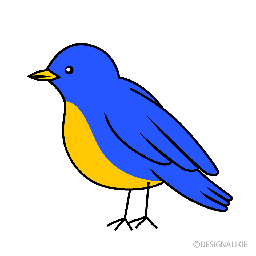

In [15]:
bird_url = "https://illustoon.com/photo/2954.png"
download_url(bird_url, "bird.jpg", show_progress=False)
Image.open('bird.jpg').to_thumb(256, 256)

In [17]:
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability: {probs[0]:.4f}")

This is a: bird.
Probability: 0.9999
